In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/4)
overlap = int(SR/8)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=10,
                        random_state=42
                       )
df = df[df.h_target == 0]

In [6]:
red_class = [classes[i] for i in df.target.unique()]

In [7]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.0,720.000000,720.000000
mean,67.819798,42.823523,34.995841,31.328895,28.970010,29.315321,29.422212,30.264358,30.262114,29.674761,...,-0.008731,-0.002821,13.914429,25.400213,4.712053,23.775889,5.429616,0.0,11.888889,5.437500
std,19.862366,11.766164,11.160478,9.574140,9.660303,9.970714,9.927495,10.616370,10.476887,10.191786,...,0.184626,0.176112,3.990155,9.797895,1.763875,7.248175,2.010476,0.0,9.170849,2.825767
min,19.660284,8.464712,6.983684,6.051917,4.978565,5.872461,6.338846,6.805765,7.045618,4.993775,...,-0.841209,-1.047266,6.801967,10.621702,2.137156,10.727984,1.620770,0.0,0.000000,1.000000
25%,53.903209,34.865271,27.183448,24.196861,21.424882,21.252925,21.612357,21.949098,22.915657,22.130270,...,-0.094403,-0.092955,11.008412,21.220999,3.686901,18.283394,3.750450,0.0,4.000000,3.000000
50%,66.945271,41.520111,32.466024,29.666294,27.382216,28.189588,28.706164,29.731419,30.188715,29.743130,...,-0.001583,0.004584,13.142669,24.228273,4.497776,22.363690,5.194630,0.0,8.500000,5.000000
75%,79.699173,49.798975,41.472934,37.837408,34.720573,36.004719,35.978369,37.107040,37.350239,36.399898,...,0.081951,0.098294,15.916472,28.011385,5.257559,27.690321,6.785829,0.0,21.000000,8.000000
max,210.860506,88.311209,84.867923,61.959582,62.229435,55.901915,65.274449,68.136665,68.936057,67.168626,...,0.708718,0.649018,37.626974,227.113393,21.216221,62.372815,13.888391,0.0,28.000000,10.000000


In [8]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [9]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['target']

# Training

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

In [11]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(30,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(18, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [12]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
feat_red = PCA(n_components=30)
feat_red.fit(train_X,y=train_y)
train_X = feat_red.transform(train_X)

clf = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=1000, 
                       batch_size=256, 
                       validation_split=0.15)

history = clf.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1984      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

Epoch 49/1000
442/442 [==============================] - 0s 33us/step - loss: 2.0436 - acc: 0.3009 - val_loss: 2.1614 - val_acc: 0.2821
Epoch 50/1000
442/442 [==============================] - 0s 32us/step - loss: 2.0501 - acc: 0.3167 - val_loss: 2.1475 - val_acc: 0.2949
Epoch 51/1000
442/442 [==============================] - 0s 33us/step - loss: 2.0332 - acc: 0.2805 - val_loss: 2.1353 - val_acc: 0.3333
Epoch 52/1000
442/442 [==============================] - 0s 34us/step - loss: 2.0548 - acc: 0.3054 - val_loss: 2.1069 - val_acc: 0.3590
Epoch 53/1000
442/442 [==============================] - 0s 30us/step - loss: 1.9694 - acc: 0.3009 - val_loss: 2.1061 - val_acc: 0.3333
Epoch 54/1000
442/442 [==============================] - 0s 34us/step - loss: 2.0277 - acc: 0.2873 - val_loss: 2.1108 - val_acc: 0.3333
Epoch 55/1000
442/442 [==============================] - 0s 34us/step - loss: 1.9773 - acc: 0.3326 - val_loss: 2.0872 - val_acc: 0.3590
Epoch 56/1000
442/442 [=========================

442/442 [==============================] - 0s 34us/step - loss: 1.5449 - acc: 0.4457 - val_loss: 1.8309 - val_acc: 0.4615
Epoch 110/1000
442/442 [==============================] - 0s 33us/step - loss: 1.6137 - acc: 0.4412 - val_loss: 1.8034 - val_acc: 0.4487
Epoch 111/1000
442/442 [==============================] - 0s 35us/step - loss: 1.5307 - acc: 0.4593 - val_loss: 1.8173 - val_acc: 0.4103
Epoch 112/1000
442/442 [==============================] - 0s 37us/step - loss: 1.5094 - acc: 0.5136 - val_loss: 1.8191 - val_acc: 0.4487
Epoch 113/1000
442/442 [==============================] - 0s 33us/step - loss: 1.5413 - acc: 0.4819 - val_loss: 1.8162 - val_acc: 0.4231
Epoch 114/1000
442/442 [==============================] - 0s 35us/step - loss: 1.5314 - acc: 0.4593 - val_loss: 1.8206 - val_acc: 0.4615
Epoch 115/1000
442/442 [==============================] - 0s 35us/step - loss: 1.5413 - acc: 0.4502 - val_loss: 1.8310 - val_acc: 0.4231
Epoch 116/1000
442/442 [==============================] 

442/442 [==============================] - 0s 37us/step - loss: 1.2870 - acc: 0.5362 - val_loss: 1.8307 - val_acc: 0.4744
Epoch 169/1000
442/442 [==============================] - 0s 35us/step - loss: 1.2637 - acc: 0.5520 - val_loss: 1.7664 - val_acc: 0.4359
Epoch 170/1000
442/442 [==============================] - 0s 34us/step - loss: 1.1963 - acc: 0.5724 - val_loss: 1.7756 - val_acc: 0.4615
Epoch 171/1000
442/442 [==============================] - 0s 34us/step - loss: 1.2758 - acc: 0.5679 - val_loss: 1.7783 - val_acc: 0.4487
Epoch 172/1000
442/442 [==============================] - 0s 34us/step - loss: 1.2639 - acc: 0.5498 - val_loss: 1.8121 - val_acc: 0.5000
Epoch 173/1000
442/442 [==============================] - 0s 38us/step - loss: 1.2977 - acc: 0.5452 - val_loss: 1.8531 - val_acc: 0.4487
Epoch 174/1000
442/442 [==============================] - 0s 33us/step - loss: 1.2498 - acc: 0.5588 - val_loss: 1.8757 - val_acc: 0.4487
Epoch 175/1000
442/442 [==============================] 

Epoch 228/1000
442/442 [==============================] - 0s 33us/step - loss: 1.0516 - acc: 0.5928 - val_loss: 1.8848 - val_acc: 0.4487
Epoch 229/1000
442/442 [==============================] - 0s 33us/step - loss: 1.0111 - acc: 0.6244 - val_loss: 1.9189 - val_acc: 0.4872
Epoch 230/1000
442/442 [==============================] - 0s 32us/step - loss: 1.0231 - acc: 0.6335 - val_loss: 1.8778 - val_acc: 0.4487
Epoch 231/1000
442/442 [==============================] - 0s 33us/step - loss: 1.0338 - acc: 0.6312 - val_loss: 1.8955 - val_acc: 0.4487
Epoch 232/1000
442/442 [==============================] - 0s 33us/step - loss: 1.0189 - acc: 0.6493 - val_loss: 1.8658 - val_acc: 0.4487
Epoch 233/1000
442/442 [==============================] - 0s 35us/step - loss: 1.0571 - acc: 0.6176 - val_loss: 1.9353 - val_acc: 0.4359
Epoch 234/1000
442/442 [==============================] - 0s 32us/step - loss: 1.0508 - acc: 0.6312 - val_loss: 1.9155 - val_acc: 0.4615
Epoch 235/1000
442/442 [=================

Epoch 288/1000
442/442 [==============================] - 0s 37us/step - loss: 0.9003 - acc: 0.6719 - val_loss: 2.0532 - val_acc: 0.4487
Epoch 289/1000
442/442 [==============================] - 0s 33us/step - loss: 0.9421 - acc: 0.6448 - val_loss: 2.0219 - val_acc: 0.4231
Epoch 290/1000
442/442 [==============================] - 0s 31us/step - loss: 0.8385 - acc: 0.6991 - val_loss: 2.0821 - val_acc: 0.4744
Epoch 291/1000
442/442 [==============================] - 0s 32us/step - loss: 0.8912 - acc: 0.6878 - val_loss: 2.0472 - val_acc: 0.4487
Epoch 292/1000
442/442 [==============================] - 0s 36us/step - loss: 0.8707 - acc: 0.6855 - val_loss: 2.0577 - val_acc: 0.4359
Epoch 293/1000
442/442 [==============================] - 0s 35us/step - loss: 0.8957 - acc: 0.6652 - val_loss: 2.0727 - val_acc: 0.4359
Epoch 294/1000
442/442 [==============================] - 0s 34us/step - loss: 0.9042 - acc: 0.6584 - val_loss: 2.0480 - val_acc: 0.4231
Epoch 295/1000
442/442 [=================

Epoch 348/1000
442/442 [==============================] - 0s 36us/step - loss: 0.7739 - acc: 0.7240 - val_loss: 2.1297 - val_acc: 0.5385
Epoch 349/1000
442/442 [==============================] - 0s 34us/step - loss: 0.8170 - acc: 0.7104 - val_loss: 2.1275 - val_acc: 0.5128
Epoch 350/1000
442/442 [==============================] - 0s 35us/step - loss: 0.6785 - acc: 0.7647 - val_loss: 2.1828 - val_acc: 0.5000
Epoch 351/1000
442/442 [==============================] - 0s 30us/step - loss: 0.7392 - acc: 0.7353 - val_loss: 2.1697 - val_acc: 0.5128
Epoch 352/1000
442/442 [==============================] - 0s 31us/step - loss: 0.7711 - acc: 0.7081 - val_loss: 2.1217 - val_acc: 0.5385
Epoch 353/1000
442/442 [==============================] - 0s 32us/step - loss: 0.7567 - acc: 0.7376 - val_loss: 2.1382 - val_acc: 0.5000
Epoch 354/1000
442/442 [==============================] - 0s 33us/step - loss: 0.7729 - acc: 0.7172 - val_loss: 2.1282 - val_acc: 0.5000
Epoch 355/1000
442/442 [=================

Epoch 408/1000
442/442 [==============================] - 0s 33us/step - loss: 0.6323 - acc: 0.7602 - val_loss: 2.2645 - val_acc: 0.5256
Epoch 409/1000
442/442 [==============================] - 0s 37us/step - loss: 0.6335 - acc: 0.7851 - val_loss: 2.3016 - val_acc: 0.5385
Epoch 410/1000
442/442 [==============================] - 0s 36us/step - loss: 0.6380 - acc: 0.7851 - val_loss: 2.2615 - val_acc: 0.5513
Epoch 411/1000
442/442 [==============================] - 0s 36us/step - loss: 0.6683 - acc: 0.7760 - val_loss: 2.2426 - val_acc: 0.5513
Epoch 412/1000
442/442 [==============================] - 0s 37us/step - loss: 0.6069 - acc: 0.7896 - val_loss: 2.3445 - val_acc: 0.5128
Epoch 413/1000
442/442 [==============================] - 0s 37us/step - loss: 0.6433 - acc: 0.7760 - val_loss: 2.2529 - val_acc: 0.5128
Epoch 414/1000
442/442 [==============================] - 0s 36us/step - loss: 0.6672 - acc: 0.7579 - val_loss: 2.3027 - val_acc: 0.5000
Epoch 415/1000
442/442 [=================

Epoch 468/1000
442/442 [==============================] - 0s 36us/step - loss: 0.5692 - acc: 0.7941 - val_loss: 2.4140 - val_acc: 0.5128
Epoch 469/1000
442/442 [==============================] - 0s 33us/step - loss: 0.5338 - acc: 0.8122 - val_loss: 2.3412 - val_acc: 0.5385
Epoch 470/1000
442/442 [==============================] - 0s 31us/step - loss: 0.5614 - acc: 0.7986 - val_loss: 2.3315 - val_acc: 0.5128
Epoch 471/1000
442/442 [==============================] - 0s 34us/step - loss: 0.5967 - acc: 0.7919 - val_loss: 2.3041 - val_acc: 0.5256
Epoch 472/1000
442/442 [==============================] - 0s 34us/step - loss: 0.4893 - acc: 0.8235 - val_loss: 2.3197 - val_acc: 0.5256
Epoch 473/1000
442/442 [==============================] - 0s 38us/step - loss: 0.5674 - acc: 0.7828 - val_loss: 2.3620 - val_acc: 0.5000
Epoch 474/1000
442/442 [==============================] - 0s 35us/step - loss: 0.5421 - acc: 0.8190 - val_loss: 2.3229 - val_acc: 0.5128
Epoch 475/1000
442/442 [=================

Epoch 528/1000
442/442 [==============================] - 0s 34us/step - loss: 0.5472 - acc: 0.8145 - val_loss: 2.3363 - val_acc: 0.5128
Epoch 529/1000
442/442 [==============================] - 0s 35us/step - loss: 0.5296 - acc: 0.8145 - val_loss: 2.3526 - val_acc: 0.5256
Epoch 530/1000
442/442 [==============================] - 0s 34us/step - loss: 0.5292 - acc: 0.8145 - val_loss: 2.3042 - val_acc: 0.5128
Epoch 531/1000
442/442 [==============================] - 0s 42us/step - loss: 0.4914 - acc: 0.8281 - val_loss: 2.2932 - val_acc: 0.5128
Epoch 532/1000
442/442 [==============================] - 0s 44us/step - loss: 0.5088 - acc: 0.8326 - val_loss: 2.2697 - val_acc: 0.5128
Epoch 533/1000
442/442 [==============================] - 0s 35us/step - loss: 0.5249 - acc: 0.8122 - val_loss: 2.3002 - val_acc: 0.5128
Epoch 534/1000
442/442 [==============================] - 0s 34us/step - loss: 0.5337 - acc: 0.8213 - val_loss: 2.2905 - val_acc: 0.5128
Epoch 535/1000
442/442 [=================

Epoch 588/1000
442/442 [==============================] - 0s 31us/step - loss: 0.4415 - acc: 0.8552 - val_loss: 2.3469 - val_acc: 0.5385
Epoch 589/1000
442/442 [==============================] - 0s 31us/step - loss: 0.4319 - acc: 0.8575 - val_loss: 2.3222 - val_acc: 0.5385
Epoch 590/1000
442/442 [==============================] - 0s 35us/step - loss: 0.4472 - acc: 0.8371 - val_loss: 2.3234 - val_acc: 0.5256
Epoch 591/1000
442/442 [==============================] - 0s 35us/step - loss: 0.4913 - acc: 0.8439 - val_loss: 2.3823 - val_acc: 0.5385
Epoch 592/1000
442/442 [==============================] - 0s 31us/step - loss: 0.4117 - acc: 0.8643 - val_loss: 2.3527 - val_acc: 0.5385
Epoch 593/1000
442/442 [==============================] - 0s 33us/step - loss: 0.4899 - acc: 0.8484 - val_loss: 2.3448 - val_acc: 0.5256
Epoch 594/1000
442/442 [==============================] - 0s 33us/step - loss: 0.4606 - acc: 0.8484 - val_loss: 2.3681 - val_acc: 0.5513
Epoch 595/1000
442/442 [=================

Epoch 648/1000
442/442 [==============================] - 0s 35us/step - loss: 0.4038 - acc: 0.8643 - val_loss: 2.4292 - val_acc: 0.5385
Epoch 649/1000
442/442 [==============================] - 0s 33us/step - loss: 0.4392 - acc: 0.8507 - val_loss: 2.4588 - val_acc: 0.5641
Epoch 650/1000
442/442 [==============================] - 0s 32us/step - loss: 0.3955 - acc: 0.8620 - val_loss: 2.4498 - val_acc: 0.5769
Epoch 651/1000
442/442 [==============================] - 0s 31us/step - loss: 0.3723 - acc: 0.8801 - val_loss: 2.4914 - val_acc: 0.5641
Epoch 652/1000
442/442 [==============================] - 0s 33us/step - loss: 0.4048 - acc: 0.8846 - val_loss: 2.4789 - val_acc: 0.5513
Epoch 653/1000
442/442 [==============================] - 0s 35us/step - loss: 0.3888 - acc: 0.8643 - val_loss: 2.4603 - val_acc: 0.5385
Epoch 654/1000
442/442 [==============================] - 0s 34us/step - loss: 0.5141 - acc: 0.8213 - val_loss: 2.4991 - val_acc: 0.5385
Epoch 655/1000
442/442 [=================

Epoch 708/1000
442/442 [==============================] - 0s 33us/step - loss: 0.3797 - acc: 0.8688 - val_loss: 2.4642 - val_acc: 0.5641
Epoch 709/1000
442/442 [==============================] - 0s 35us/step - loss: 0.3809 - acc: 0.8710 - val_loss: 2.4707 - val_acc: 0.5513
Epoch 710/1000
442/442 [==============================] - 0s 35us/step - loss: 0.3797 - acc: 0.8710 - val_loss: 2.4542 - val_acc: 0.5513
Epoch 711/1000
442/442 [==============================] - 0s 31us/step - loss: 0.4203 - acc: 0.8801 - val_loss: 2.4675 - val_acc: 0.5641
Epoch 712/1000
442/442 [==============================] - 0s 29us/step - loss: 0.3387 - acc: 0.8869 - val_loss: 2.5071 - val_acc: 0.5513
Epoch 713/1000
442/442 [==============================] - 0s 32us/step - loss: 0.3697 - acc: 0.8733 - val_loss: 2.4596 - val_acc: 0.5513
Epoch 714/1000
442/442 [==============================] - 0s 31us/step - loss: 0.4405 - acc: 0.8665 - val_loss: 2.4865 - val_acc: 0.5641
Epoch 715/1000
442/442 [=================

Epoch 768/1000
442/442 [==============================] - 0s 35us/step - loss: 0.3039 - acc: 0.9005 - val_loss: 2.5155 - val_acc: 0.5769
Epoch 769/1000
442/442 [==============================] - 0s 37us/step - loss: 0.3945 - acc: 0.8756 - val_loss: 2.4806 - val_acc: 0.5769
Epoch 770/1000
442/442 [==============================] - 0s 33us/step - loss: 0.3016 - acc: 0.8869 - val_loss: 2.5231 - val_acc: 0.5641
Epoch 771/1000
442/442 [==============================] - 0s 37us/step - loss: 0.2981 - acc: 0.9050 - val_loss: 2.5519 - val_acc: 0.5641
Epoch 772/1000
442/442 [==============================] - 0s 33us/step - loss: 0.3151 - acc: 0.9050 - val_loss: 2.5198 - val_acc: 0.5769
Epoch 773/1000
442/442 [==============================] - 0s 38us/step - loss: 0.3189 - acc: 0.9095 - val_loss: 2.5388 - val_acc: 0.5513
Epoch 774/1000
442/442 [==============================] - 0s 36us/step - loss: 0.3514 - acc: 0.8643 - val_loss: 2.5122 - val_acc: 0.5769
Epoch 775/1000
442/442 [=================

Epoch 828/1000
442/442 [==============================] - 0s 31us/step - loss: 0.3258 - acc: 0.8778 - val_loss: 2.6089 - val_acc: 0.5256
Epoch 829/1000
442/442 [==============================] - 0s 35us/step - loss: 0.3013 - acc: 0.8914 - val_loss: 2.6078 - val_acc: 0.5513
Epoch 830/1000
442/442 [==============================] - 0s 33us/step - loss: 0.3042 - acc: 0.9118 - val_loss: 2.5869 - val_acc: 0.5769
Epoch 831/1000
442/442 [==============================] - 0s 34us/step - loss: 0.3775 - acc: 0.8869 - val_loss: 2.5581 - val_acc: 0.5897
Epoch 832/1000
442/442 [==============================] - 0s 34us/step - loss: 0.3521 - acc: 0.8914 - val_loss: 2.5486 - val_acc: 0.5897
Epoch 833/1000
442/442 [==============================] - 0s 32us/step - loss: 0.3408 - acc: 0.8801 - val_loss: 2.5569 - val_acc: 0.5641
Epoch 834/1000
442/442 [==============================] - 0s 30us/step - loss: 0.2833 - acc: 0.9118 - val_loss: 2.5481 - val_acc: 0.5513
Epoch 835/1000
442/442 [=================

Epoch 888/1000
442/442 [==============================] - 0s 33us/step - loss: 0.2622 - acc: 0.9072 - val_loss: 2.4770 - val_acc: 0.5641
Epoch 889/1000
442/442 [==============================] - 0s 35us/step - loss: 0.2714 - acc: 0.9163 - val_loss: 2.5009 - val_acc: 0.5897
Epoch 890/1000
442/442 [==============================] - 0s 33us/step - loss: 0.2808 - acc: 0.9231 - val_loss: 2.5192 - val_acc: 0.5769
Epoch 891/1000
442/442 [==============================] - 0s 32us/step - loss: 0.2907 - acc: 0.9027 - val_loss: 2.4825 - val_acc: 0.6026
Epoch 892/1000
442/442 [==============================] - 0s 33us/step - loss: 0.2375 - acc: 0.9050 - val_loss: 2.4980 - val_acc: 0.5897
Epoch 893/1000
442/442 [==============================] - 0s 34us/step - loss: 0.3596 - acc: 0.8778 - val_loss: 2.4559 - val_acc: 0.5897
Epoch 894/1000
442/442 [==============================] - 0s 35us/step - loss: 0.2793 - acc: 0.9050 - val_loss: 2.4928 - val_acc: 0.5897
Epoch 895/1000
442/442 [=================

Epoch 948/1000
442/442 [==============================] - 0s 37us/step - loss: 0.3372 - acc: 0.8914 - val_loss: 2.4822 - val_acc: 0.5385
Epoch 949/1000
442/442 [==============================] - 0s 33us/step - loss: 0.2875 - acc: 0.9118 - val_loss: 2.5368 - val_acc: 0.5385
Epoch 950/1000
442/442 [==============================] - 0s 34us/step - loss: 0.3255 - acc: 0.8982 - val_loss: 2.4767 - val_acc: 0.5641
Epoch 951/1000
442/442 [==============================] - 0s 37us/step - loss: 0.2565 - acc: 0.9095 - val_loss: 2.5997 - val_acc: 0.5641
Epoch 952/1000
442/442 [==============================] - 0s 35us/step - loss: 0.2630 - acc: 0.9208 - val_loss: 2.5813 - val_acc: 0.5769
Epoch 953/1000
442/442 [==============================] - 0s 35us/step - loss: 0.2776 - acc: 0.9276 - val_loss: 2.5289 - val_acc: 0.5513
Epoch 954/1000
442/442 [==============================] - 0s 33us/step - loss: 0.3052 - acc: 0.9095 - val_loss: 2.5585 - val_acc: 0.5641
Epoch 955/1000
442/442 [=================

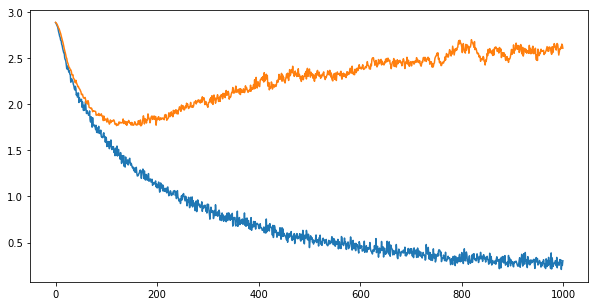

In [13]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

0.3816793893129771
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 2 1 0 1 0 0 0 0 1 0 1 0]
 [0 1 1 4 0 0 0 0 2 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0]
 [0 1 0 1 0 2 0 0 2 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0]
 [0 0 1 2 0 0 0 5 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 1 0 3 2 0 0 0 0 0 0 1]
 [0 0 0 0 2 0 0 0 2 4 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 6 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 4 3 1 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0]
 [2 0 0 0 0 0 2 0 1 1 1 1 0 0 0 0 3 0]
 [0 0 1 0 0 0 0 0 0 0 1 0 0 0 2 0 0 2]]


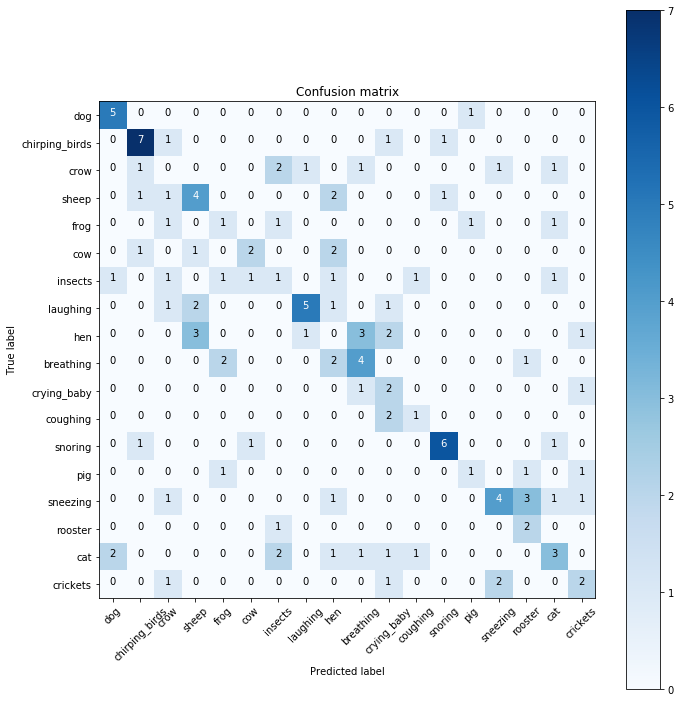

In [14]:
test_X = scaler.transform(test_X)
test_X = feat_red.transform(test_X)

pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, red_class)
plt.show()

# All Data

In [15]:
all_df = df[df.fold == 1]

In [16]:
all_df.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
29,92.424748,59.141242,36.846606,20.968241,15.579660,15.751939,15.863563,14.673644,13.023693,10.921275,...,0.080787,-0.115509,18.608194,36.212375,6.859917,33.937771,7.555853,0,8,1
49,80.026334,43.699629,33.855491,26.743481,29.245538,31.119842,25.972480,25.312478,25.158757,22.965982,...,0.006161,0.251638,13.626741,18.341014,4.690726,17.136722,11.156650,0,3,1
69,70.094849,35.303785,37.217964,40.640240,32.847498,28.306000,34.013978,37.584400,35.427584,38.294607,...,0.082853,0.128150,12.071106,23.774442,3.617514,20.146890,3.616052,0,4,1
70,87.377102,49.914426,30.097184,22.802098,15.322698,15.842010,14.771730,16.588904,13.791249,14.447621,...,0.212866,-0.130597,13.832251,24.141363,4.688349,20.221107,4.571539,0,6,1
99,78.710584,42.940635,37.168224,37.558247,33.906472,35.008088,35.526903,32.724747,31.633630,34.935675,...,0.070440,-0.012688,10.606953,21.664868,4.289510,19.193632,6.182659,0,2,1


In [17]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['target']
X = scaler.transform(X)
X = feat_red.transform(X)

0.391304347826087
Confusion matrix, without normalization
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 2]
 [0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 2 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 3 0 1 0 0 0 0 1 1 0 0 0 0]
 [1 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 2 2 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]]


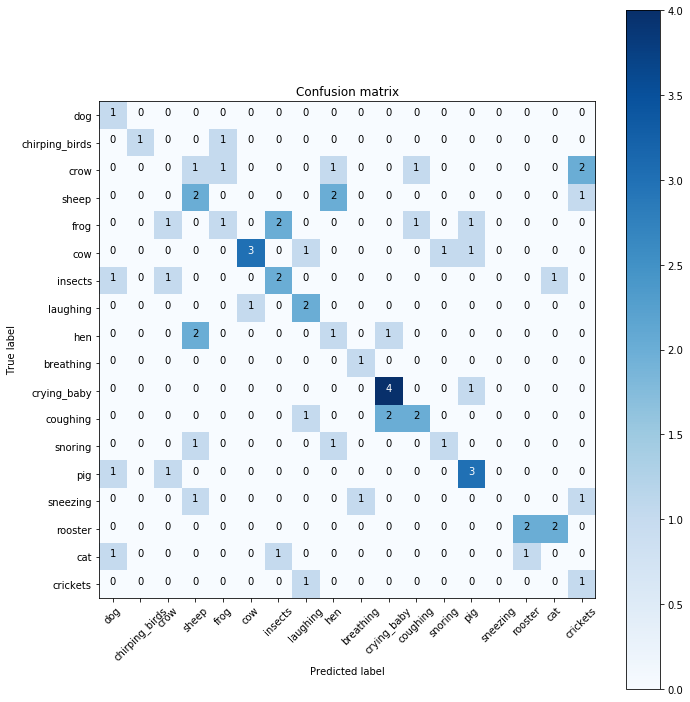

In [18]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, red_class)
plt.show()

In [19]:
import seaborn as sns
misclassified = {
    'actual': [],
    'predicted': []
}
for cls in red_class:
    misclassified[cls] = []

for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['actual'].append(classes[int(row[1]['target'])])
        misclassified['predicted'].append(classes[p])
        for i, cls in enumerate(red_class):
            misclassified[cls].append(prob[i])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,actual,breathing,cat,chirping_birds,coughing,cow,crickets,crow,crying_baby,dog,frog,hen,insects,laughing,pig,predicted,rooster,sheep,sneezing,snoring
0,sheep,0.000181,5.466349e-06,0.085033,8.615888e-03,0.111751,0.003829,0.000128,0.400701,1.804111e-03,8.134788e-05,2.738796e-04,1.082728e-04,0.000957,0.371749,crickets,3.925098e-03,1.981420e-06,1.317278e-04,1.072306e-02
1,frog,0.000271,3.623644e-05,0.000002,1.420886e-04,0.000136,0.000138,0.801603,0.001280,6.977592e-05,1.951327e-01,9.696245e-09,1.134946e-03,0.000048,0.000005,pig,1.214013e-07,4.348571e-09,6.255439e-08,6.733815e-08
2,pig,0.072207,2.616049e-02,0.000470,4.338885e-06,0.000271,0.030659,0.101405,0.000017,9.403428e-07,1.420208e-05,2.554436e-01,1.736016e-04,0.015533,0.000001,cow,1.677748e-06,4.908255e-01,3.705855e-03,3.106131e-03
3,pig,0.010284,1.126284e-03,0.003364,5.397690e-07,0.001618,0.002549,0.001149,0.000042,1.983736e-06,3.490963e-08,6.559302e-01,1.994799e-04,0.000101,0.000005,sheep,6.895069e-06,1.023856e-02,3.882599e-03,3.095009e-01
4,cat,0.000017,2.103169e-09,0.000003,3.173373e-02,0.000017,0.000386,0.000010,0.025317,1.161583e-11,6.640965e-07,4.611058e-04,4.181994e-11,0.942031,0.000017,insects,4.528615e-11,7.054040e-06,5.995250e-08,2.478995e-09


In [20]:
average_prob = misclassified.groupby('predicted').mean()
average_prob.head()

,breathing,cat,chirping_birds,coughing,cow,crickets,crow,crying_baby,dog,frog,hen,insects,laughing,pig,rooster,sheep,sneezing,snoring
predicted,,,,,,,,,,,,,,,,,,
cat,1.443069e-06,3.947180e-08,0.004721,9.467453e-05,0.813628,3.939016e-04,2.589524e-03,0.000120,6.145490e-07,2.432862e-09,9.090361e-02,8.585853e-05,0.002512,0.000045,1.204480e-07,2.253954e-03,7.023308e-08,8.265030e-02
chirping_birds,1.615360e-05,6.112522e-09,0.000231,9.439740e-01,0.000006,1.720667e-08,1.541835e-07,0.039590,7.927479e-09,9.138659e-03,4.102076e-10,3.928796e-08,0.000153,0.006890,9.581830e-09,4.526418e-11,1.229150e-09,2.870580e-11
coughing,2.086586e-08,4.790036e-03,0.000026,1.479204e-07,0.000002,4.678638e-05,1.335560e-08,0.000001,3.136111e-03,4.686442e-06,7.049456e-11,4.197733e-07,0.000103,0.028232,9.291832e-01,3.132146e-08,3.419533e-02,2.794810e-04
cow,1.504285e-02,6.589026e-03,0.002497,2.653161e-06,0.000123,2.591628e-02,2.345870e-02,0.000009,2.574281e-07,3.266632e-06,1.411497e-01,3.595410e-05,0.033901,0.000002,1.327961e-06,7.483763e-01,1.872681e-03,1.019266e-03
crickets,7.553837e-05,1.822378e-06,0.028346,5.062415e-02,0.037252,1.301162e-03,4.265096e-05,0.748867,6.013705e-04,6.676865e-05,9.144355e-05,3.609095e-05,0.003698,0.124069,1.308366e-03,6.608026e-07,4.394778e-05,3.574354e-03


In [21]:
average_prob = misclassified.groupby('actual').mean()
average_prob

,breathing,cat,chirping_birds,coughing,cow,crickets,crow,crying_baby,dog,frog,hen,insects,laughing,pig,rooster,sheep,sneezing,snoring
actual,,,,,,,,,,,,,,,,,,
breathing,2.467536e-01,2.522331e-02,3.954631e-04,1.020256e-06,4.966353e-07,3.244906e-01,6.417121e-05,2.047376e-05,5.884007e-06,1.427205e-04,2.005222e-02,3.098145e-05,1.472223e-03,6.900936e-06,2.387010e-05,3.137871e-01,6.706158e-02,4.673481e-04
cat,5.790728e-06,2.228713e-07,2.283361e-02,1.060398e-02,9.837733e-02,1.286607e-04,3.478981e-06,8.484456e-03,2.282473e-04,1.913677e-06,1.538381e-04,3.985785e-05,3.140118e-01,3.172546e-01,1.551063e-02,1.775601e-05,6.888246e-07,2.123431e-01
chirping_birds,2.033781e-05,2.762580e-10,1.253815e-06,5.569253e-02,2.065983e-06,2.519007e-04,5.675528e-07,7.484027e-01,1.118137e-10,3.977028e-05,6.098456e-05,1.498205e-11,1.953719e-01,1.559050e-04,2.708418e-10,3.469083e-08,4.548800e-08,6.220344e-11
coughing,1.183556e-01,6.047077e-01,6.723978e-04,3.678252e-04,2.689394e-04,8.991076e-03,1.017793e-02,9.830638e-03,2.244808e-02,4.607961e-02,1.522035e-04,8.353481e-02,1.391048e-03,1.388463e-03,1.802331e-03,3.724368e-05,8.836014e-02,1.433998e-03
cow,8.292638e-03,1.847850e-03,1.818914e-05,8.227559e-06,7.564969e-05,2.439050e-01,1.097636e-01,1.725341e-04,3.823195e-05,1.599004e-04,3.877780e-01,4.161685e-06,6.922571e-02,5.058969e-05,2.294405e-05,1.762506e-01,2.287767e-03,9.843577e-05
crickets,1.272701e-14,4.348939e-14,1.101594e-05,1.214476e-05,4.953932e-07,1.906610e-09,2.692498e-16,3.569188e-04,1.452843e-08,9.787256e-11,2.469908e-16,5.196703e-15,2.743688e-07,9.996136e-01,5.706633e-06,1.381623e-17,8.027179e-11,2.563742e-11
crying_baby,6.958382e-05,5.050318e-05,3.498725e-04,2.896041e-08,5.759263e-05,1.971931e-04,2.308911e-06,1.224727e-08,6.336105e-10,3.972818e-13,4.842452e-01,2.098352e-07,9.296911e-03,2.401102e-08,5.932121e-08,3.815122e-01,6.199021e-04,1.235983e-01
frog,1.457787e-04,4.674221e-03,5.120094e-05,1.847831e-01,3.302316e-04,2.004292e-04,1.810249e-01,6.356640e-02,9.427367e-03,7.590892e-02,2.150819e-09,3.321084e-01,9.699209e-05,1.476718e-01,9.913604e-06,8.891450e-10,2.208031e-07,1.421597e-07
hen,3.186746e-03,1.635436e-01,6.057144e-04,5.076736e-06,4.337091e-03,8.419706e-04,3.561500e-01,3.968174e-06,2.390442e-01,5.871311e-04,2.074852e-04,1.930414e-01,6.475657e-04,2.923047e-05,1.127246e-03,2.052361e-03,6.373669e-04,3.395179e-02


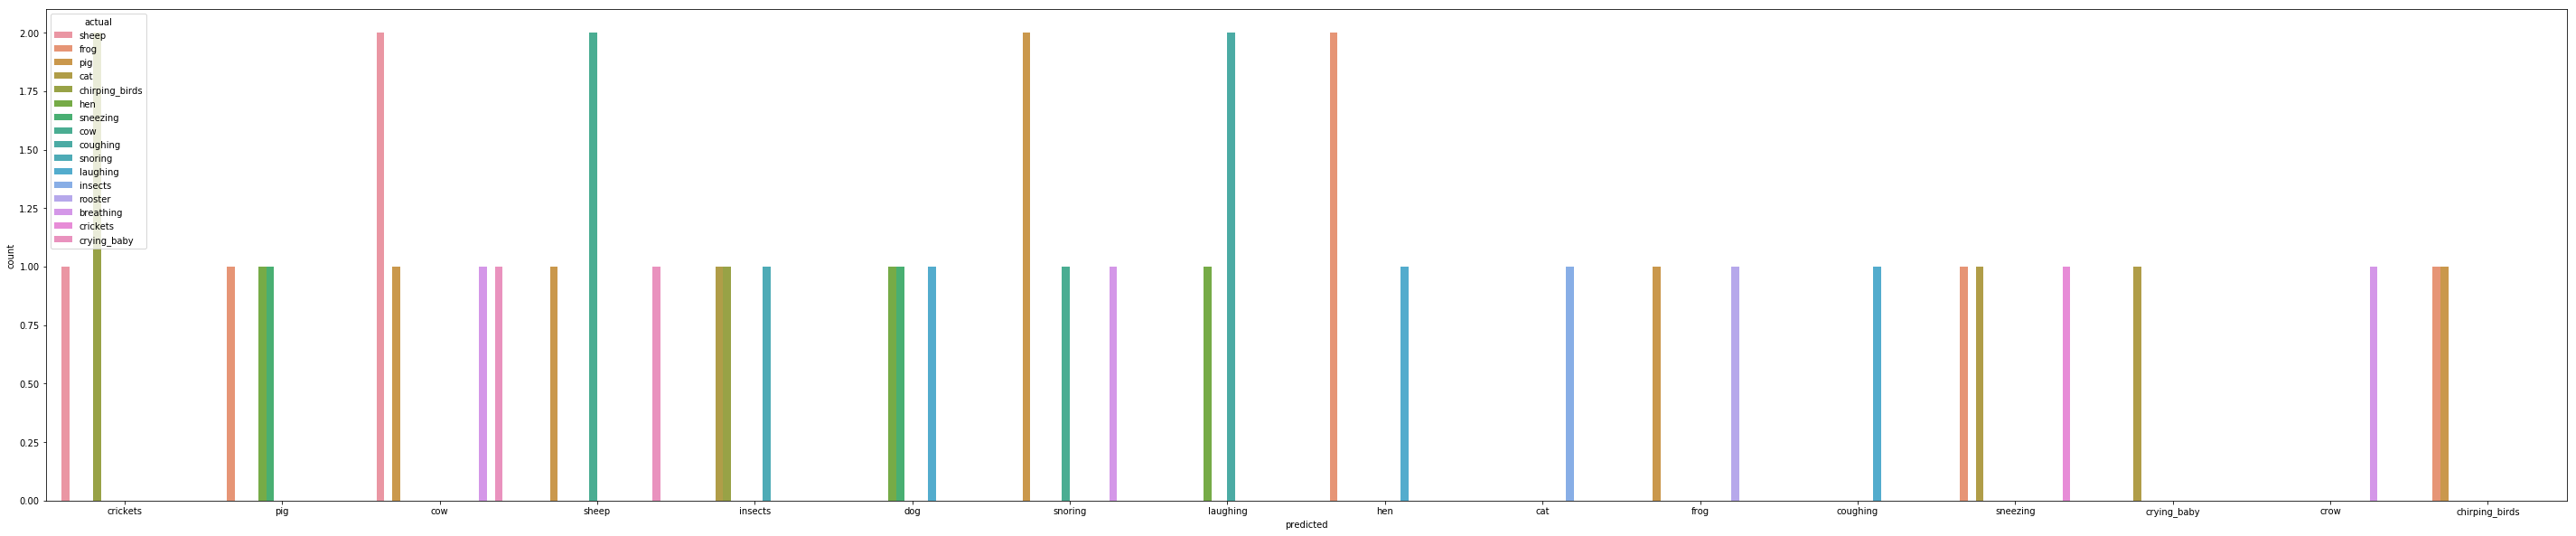

In [22]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='predicted', hue='actual',data=misclassified)